In [ ]:
import os
import numpy as np
from load_data import *
from sklearn.model_selection import train_test_split
import torch
from torch.nn import *
from models import *
from training import *
from sklearn.model_selection import KFold
from torch.utils.data import *
import matplotlib.pyplot as plt
import time

In [ ]:
# Set seed for random initialization
torch.manual_seed(0)
torch.cuda.manual_seed(0)

# Load data

In [ ]:
params, solutions, basis_space, basis_time, sv_space, sv_time = load_data()

# Upper and lower bound of params
upper_bounds_params = np.array([8.0, 0.3, 0.5, 0.5, 0.5, 0.0])
lower_bounds_params = np.array([4.0, 0.1, -0.1, -0.5, -0.5, -0.3])

# Params mapping to [0, 1]
params = (params - lower_bounds_params) / (upper_bounds_params - lower_bounds_params)

# Singular values

In [ ]:
def f(w):
	# return w
	# return w ** 2
	return torch.sqrt(w)

In [ ]:
sv_space_v = torch.tensor(sv_space['velocity'], dtype=torch.float32)
sv_space_v = f(sv_space_v)

sv_time_v = torch.tensor(sv_time['velocity'], dtype=torch.float32)
sv_time_v = f(sv_time_v)

sv_space_p = torch.tensor(sv_space['pressure'], dtype=torch.float32)
sv_space_p = f(sv_space_p)

sv_time_p = torch.tensor(sv_time['pressure'], dtype=torch.float32)
sv_time_p = f(sv_time_p)

sv_v = torch.reshape(sv_space_v.view(sv_space_v.shape[0], -1) * sv_time_v.view(-1, sv_time_v.shape[0]), (-1, sv_space_v.shape[0] * sv_time_v.shape[0])).squeeze()
sv_p = torch.reshape(sv_space_p.view(sv_space_p.shape[0], -1) * sv_time_p.view(-1, sv_time_p.shape[0]), (-1, sv_space_p.shape[0] * sv_time_p.shape[0])).squeeze()

sv_v = sv_v / torch.sum(sv_v)
sv_p = sv_p / torch.sum(sv_p)

# Split training and test set

In [ ]:
# Splitting train-test

split = 0.9

x_train_v, x_test_v, y_train_v, y_test_v = train_test_split(params, solutions['velocity'], test_size=1-split, random_state=0)
x_train_p, x_test_p, y_train_p, y_test_p = train_test_split(params, solutions['pressure'], test_size=1-split, random_state=0)

# Create Dataset objects for training and validation

In [ ]:
# Class for a dataset structure

class CreateDataset(Dataset):

    def __init__(self,x,y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y.reshape(x.shape[0], -1), dtype=torch.float32)  # unique tensor for space and time

    def __getitem__(self,index):
        sample = {
            'feature': self.x[index],
            'label': self.y[index]}
        return sample

    def __len__(self):
        return len(self.x)

# Cross validation

In [ ]:
def cross_validation(folds, x, y, PTCMap, K, sv, num_epochs, lr, device):

    kf = KFold(folds)

    errors = []
    exec_times = []

    basis_space = y.shape[1]
    basis_time = y.shape[2]

    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(x)):

        x_train, y_train, x_val, y_val = x[train_idx], y[train_idx], x[val_idx], y[val_idx]

        train = CreateDataset(x_train, y_train)
        val = CreateDataset(x_val, y_val)

        batch_size = 32

        torch.manual_seed(0)
        torch.cuda.manual_seed(0)

        train_gen = DataLoader(train, batch_size=batch_size, shuffle=True)
        val_gen = DataLoader(val, batch_size=batch_size, shuffle=True)

        model = PTCMap(K, basis_space, basis_time)

        start = time.time()

        run_training_weighted(train_gen, val_gen, num_epochs, model, sv, lr, device)

        end = time.time()
        print('Execution time: {:.0f}s'.format(end - start))
        exec_times.append(end - start)

        error, _ = compute_error(model, val_gen, device)
        errors.append(error)

    errors = np.array(errors)
    exec_times = np.array(exec_times)

    return np.mean(errors), np.std(errors), np.mean(exec_times), np.std(exec_times)

# Cross validation for velocity

In [ ]:
# Parameters

# Set device for training
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Number of neurons per layer
K = 256

# Learning rate
lr = 0.01

# Number of epochs
num_epochs = 500

# K-fold
folds = 5

Train epoch 1: loss = 1.2102864517105951, error = 0.47523123025894165, lr = 0.01
Validation epoch 1: val_loss = 0.9384316007296244, val_error = 0.30536251730389063
Train epoch 101: loss = 0.02513816633986102, error = 0.0785211788283454, lr = 0.004047319726783238
Validation epoch 101: val_loss = 0.05305044154326121, val_error = 0.09854804012510511
Train epoch 201: loss = 0.01170225613233116, error = 0.05115832024150425, lr = 0.0016380796970808745
Validation epoch 201: val_loss = 0.041840232743157284, val_error = 0.08609656559096443
Train epoch 301: loss = 0.0077941450600822765, error = 0.04079845096502039, lr = 0.0006629832272038536
Validation epoch 301: val_loss = 0.04183560030327903, val_error = 0.08449483712514241
Train epoch 401: loss = 0.006103377178725269, error = 0.034957506176498204, lr = 0.00026833050939885714
Validation epoch 401: val_loss = 0.04190779998898506, val_error = 0.08407311671310001


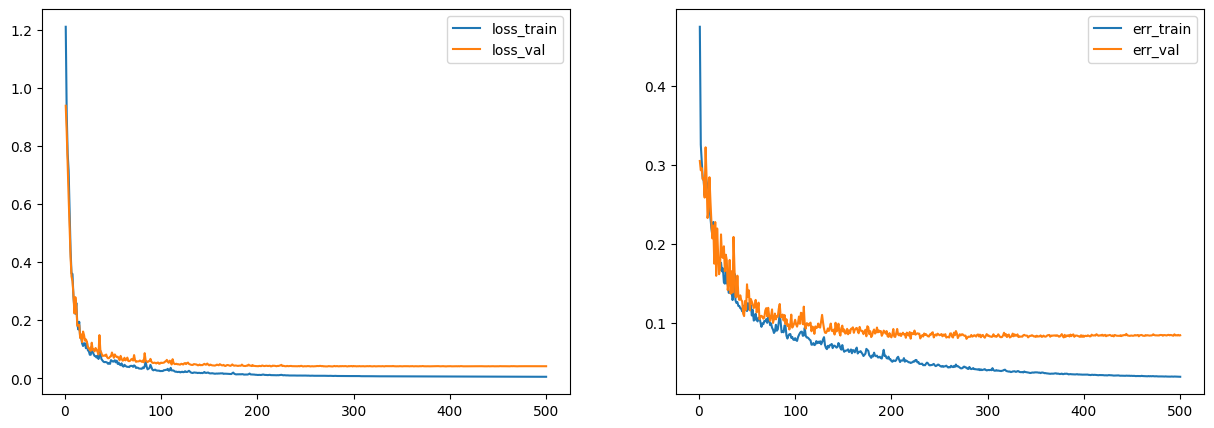

Execution time: 87s
Train epoch 1: loss = 1.20491085184945, error = 0.47667169504695467, lr = 0.01
Validation epoch 1: val_loss = 0.9766703764597575, val_error = 0.2961450371477339
Train epoch 101: loss = 0.027839481168323094, error = 0.08272426691320207, lr = 0.004047319726783238
Validation epoch 101: val_loss = 0.048707220123873816, val_error = 0.10062950236929788
Train epoch 201: loss = 0.011425925998224153, error = 0.051814071585734686, lr = 0.0016380796970808745
Validation epoch 201: val_loss = 0.03711458924743864, val_error = 0.08391593330436282
Train epoch 301: loss = 0.007612030259850952, error = 0.04123787706096967, lr = 0.0006629832272038536
Validation epoch 301: val_loss = 0.035515958981381525, val_error = 0.08032186759842766
Train epoch 401: loss = 0.006071133301075962, error = 0.0352836649864912, lr = 0.00026833050939885714
Validation epoch 401: val_loss = 0.035415728473001055, val_error = 0.07818950795465046


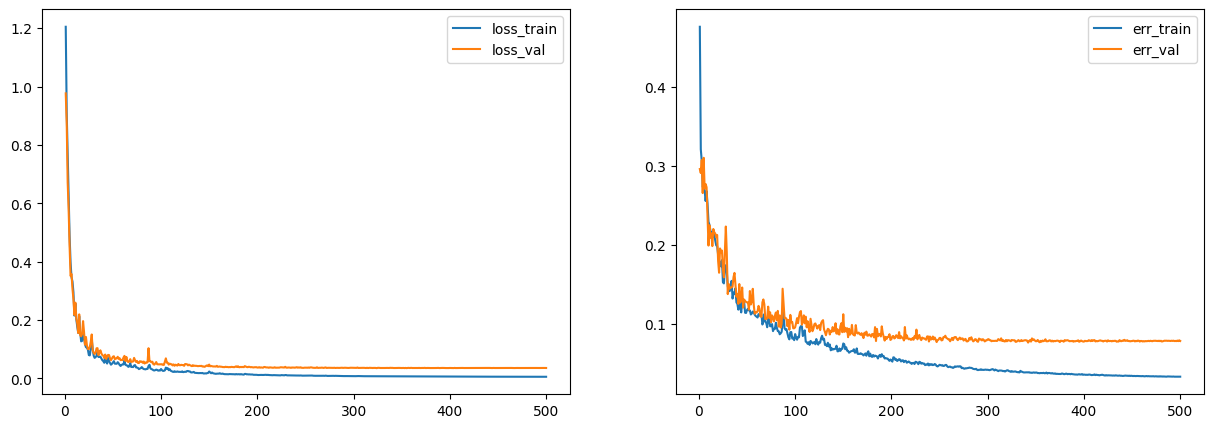

Execution time: 88s
Train epoch 1: loss = 1.2123630417717828, error = 0.4692240575949351, lr = 0.01
Validation epoch 1: val_loss = 0.9727993965148926, val_error = 0.296964599026574
Train epoch 101: loss = 0.027425695666008526, error = 0.08847294896841049, lr = 0.004047319726783238
Validation epoch 101: val_loss = 0.04228939546479119, val_error = 0.08889881951941384
Train epoch 201: loss = 0.012134287402861647, error = 0.054927799767918055, lr = 0.0016380796970808745
Validation epoch 201: val_loss = 0.03402888518240717, val_error = 0.08328646288977729
Train epoch 301: loss = 0.008005019173853926, error = 0.04009483837419086, lr = 0.0006629832272038536
Validation epoch 301: val_loss = 0.0330807834242781, val_error = 0.0759993475344446
Train epoch 401: loss = 0.006310015202810367, error = 0.03458537732561429, lr = 0.00026833050939885714
Validation epoch 401: val_loss = 0.03185830141107241, val_error = 0.07573764274517696


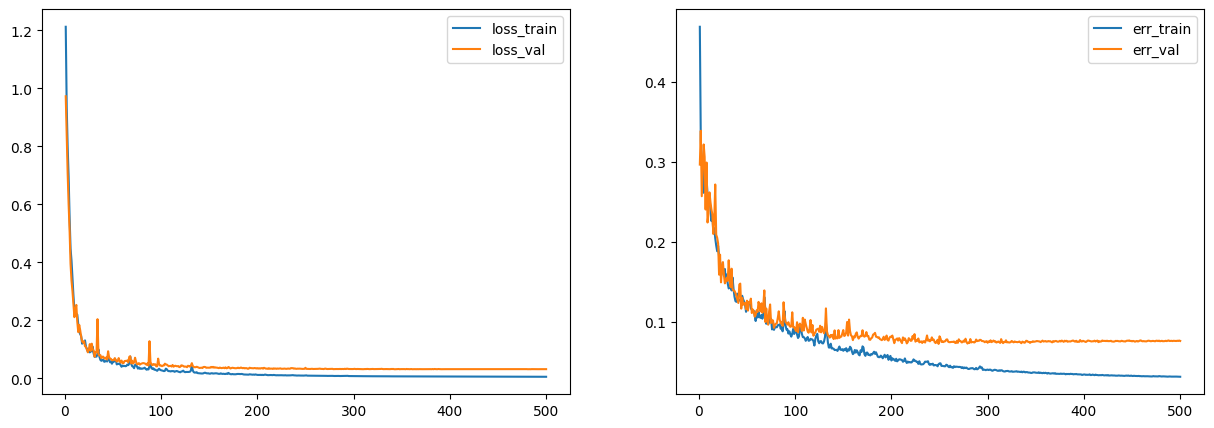

Execution time: 88s
Train epoch 1: loss = 1.2034454001320734, error = 0.4742307126522064, lr = 0.01
Validation epoch 1: val_loss = 1.026676935619778, val_error = 0.31222095357047186
Train epoch 101: loss = 0.03382967139283816, error = 0.09236317889557945, lr = 0.004047319726783238
Validation epoch 101: val_loss = 0.05463057317667537, val_error = 0.1109786268737581
Train epoch 201: loss = 0.013163426187303331, error = 0.0563030696577496, lr = 0.0016380796970808745
Validation epoch 201: val_loss = 0.046139763709571624, val_error = 0.09466087288326687
Train epoch 301: loss = 0.008461646590795782, error = 0.042901771184470916, lr = 0.0006629832272038536
Validation epoch 301: val_loss = 0.043526554438802934, val_error = 0.08840502964125739
Train epoch 401: loss = 0.006771773048159149, error = 0.037450478391514885, lr = 0.00026833050939885714
Validation epoch 401: val_loss = 0.04335381872951984, val_error = 0.09440132660998238


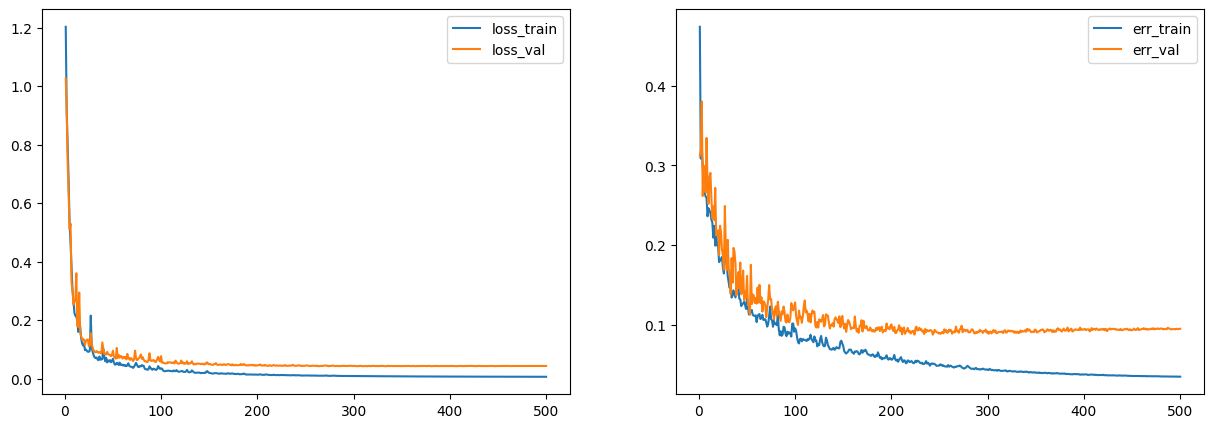

Execution time: 89s
Train epoch 1: loss = 1.2270721978611416, error = 0.5049876425001356, lr = 0.01
Validation epoch 1: val_loss = 0.9482261445787218, val_error = 0.34272738695144656
Train epoch 101: loss = 0.02961637373599741, error = 0.09055902303920851, lr = 0.004047319726783238
Validation epoch 101: val_loss = 0.04644224055939251, val_error = 0.08782170919908418
Train epoch 201: loss = 0.013052547557486428, error = 0.05555062658256955, lr = 0.0016380796970808745
Validation epoch 201: val_loss = 0.03373659054438273, val_error = 0.07657829407188628
Train epoch 301: loss = 0.008613438273055687, error = 0.04391452107164595, lr = 0.0006629832272038536
Validation epoch 301: val_loss = 0.032627435690826836, val_error = 0.07708924015363057
Train epoch 401: loss = 0.006943131610751152, error = 0.037524502807193334, lr = 0.00026833050939885714
Validation epoch 401: val_loss = 0.03172442581918505, val_error = 0.0750956505537033


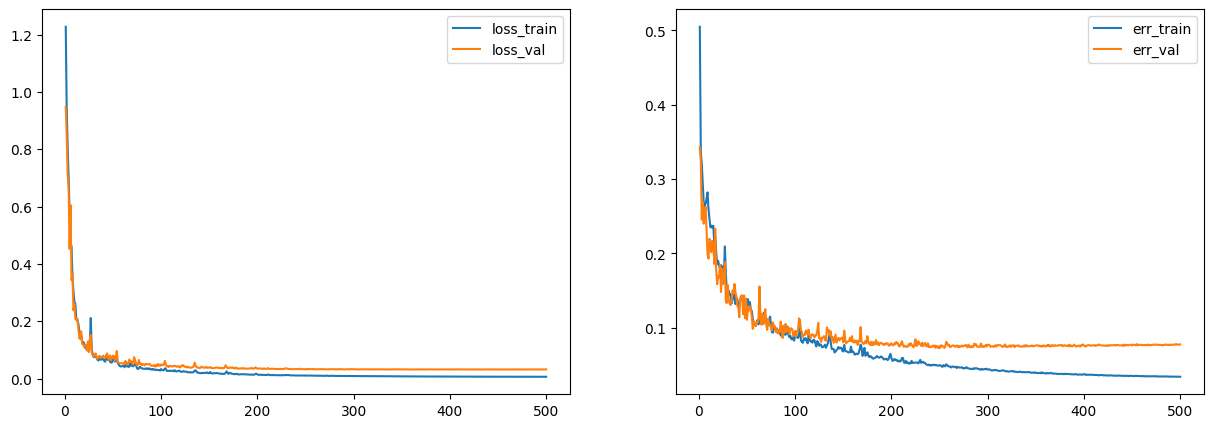

Execution time: 89s


In [ ]:
error, std, t_mean, t_std = cross_validation(folds, x_train_v, y_train_v, PTCMapVelocity, K, sv_v, num_epochs, lr, device)

In [ ]:
print("Error: mean = {:.3f}, std = {:.3f}".format(error, std))

Error: mean = 0.076, std = 0.035


In [ ]:
print("Time: mean = {:.3f}, std = {:.3f}".format(t_mean, t_std))

Time: mean = 86.158, std = 0.688


# Cross validation for pressure

In [ ]:
# Parameters

# Set device for training
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Number of neurons per layer
K = 256

# Learning rate
lr = 0.01

# Number of epochs
num_epochs = 500

# K-fold
folds = 5

Train epoch 1: loss = 3410.121644422743, error = 0.75025438202752, lr = 0.01
Validation epoch 1: val_loss = 1726.2425944010417, val_error = 0.5100958691702948
Train epoch 101: loss = 5.23414454460144, error = 0.04461054818497764, lr = 0.004047319726783238
Validation epoch 101: val_loss = 13.682371436225043, val_error = 0.04856979706221157
Train epoch 201: loss = 0.7798098160160912, error = 0.02688890476193693, lr = 0.0016380796970808745
Validation epoch 201: val_loss = 7.7221247037251795, val_error = 0.0340683739218447
Train epoch 301: loss = 0.5004828320609198, error = 0.023017141305738027, lr = 0.0006629832272038536
Validation epoch 301: val_loss = 6.703112310833401, val_error = 0.030671891487307017
Train epoch 401: loss = 0.3604805479447047, error = 0.021133411675691605, lr = 0.00026833050939885714
Validation epoch 401: val_loss = 6.507451054784987, val_error = 0.029022988428672156


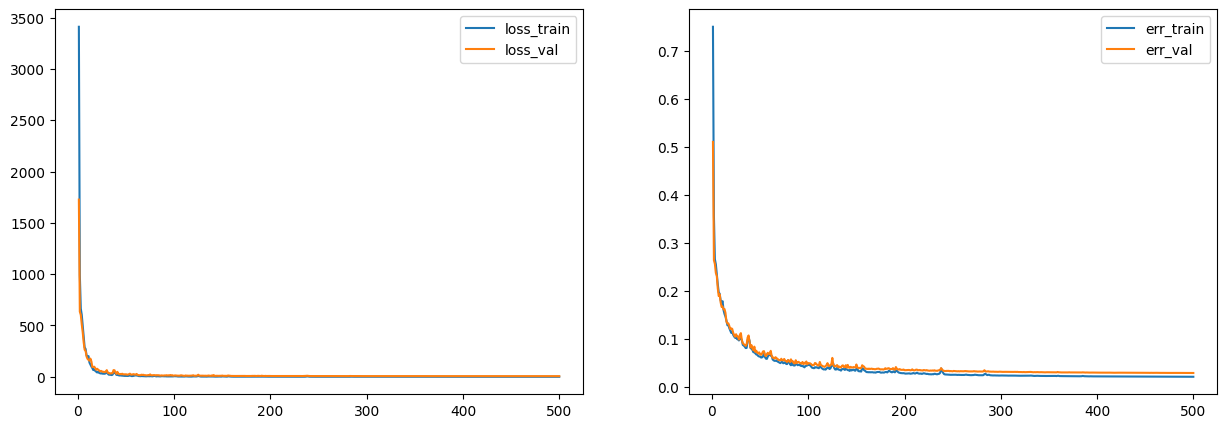

Execution time: 74s
Train epoch 1: loss = 3405.5476860894096, error = 0.7489899105495876, lr = 0.01
Validation epoch 1: val_loss = 1731.0404025607638, val_error = 0.5110253956582811
Train epoch 101: loss = 5.058744351069133, error = 0.04318777008189095, lr = 0.004047319726783238
Validation epoch 101: val_loss = 11.239976384904649, val_error = 0.052435274422168734
Train epoch 201: loss = 0.7944961395528581, error = 0.027400458686881596, lr = 0.0016380796970808745
Validation epoch 201: val_loss = 3.1833480570051407, val_error = 0.034325807127687666
Train epoch 301: loss = 0.7129169272051917, error = 0.024284589870108498, lr = 0.0006629832272038536
Validation epoch 301: val_loss = 3.0214117050170897, val_error = 0.03125919525822004
Train epoch 401: loss = 0.3521092696322335, error = 0.021336994941035907, lr = 0.00026833050939885714
Validation epoch 401: val_loss = 2.4726441780726116, val_error = 0.029080330663257176


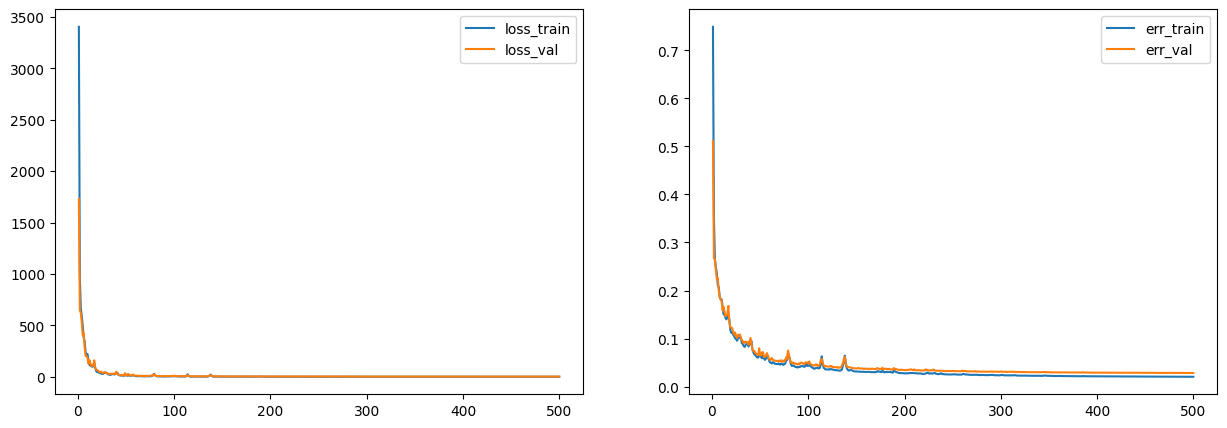

Execution time: 74s
Train epoch 1: loss = 3399.8375352647568, error = 0.7478544725312127, lr = 0.01
Validation epoch 1: val_loss = 1759.6346354166667, val_error = 0.5133991161982219
Train epoch 101: loss = 3.022772314813402, error = 0.04204566925764084, lr = 0.004047319726783238
Validation epoch 101: val_loss = 8.624524794684516, val_error = 0.0483472116291523
Train epoch 201: loss = 1.005545938014984, error = 0.029410907791720495, lr = 0.0016380796970808745
Validation epoch 201: val_loss = 4.602803497844272, val_error = 0.035747146440876856
Train epoch 301: loss = 0.5520306395159827, error = 0.024228022992610933, lr = 0.0006629832272038536
Validation epoch 301: val_loss = 4.111823983987173, val_error = 0.0318083546227879
Train epoch 401: loss = 0.3802280061774784, error = 0.021980980369779798, lr = 0.00026833050939885714
Validation epoch 401: val_loss = 3.7148825963338217, val_error = 0.029705801523394054


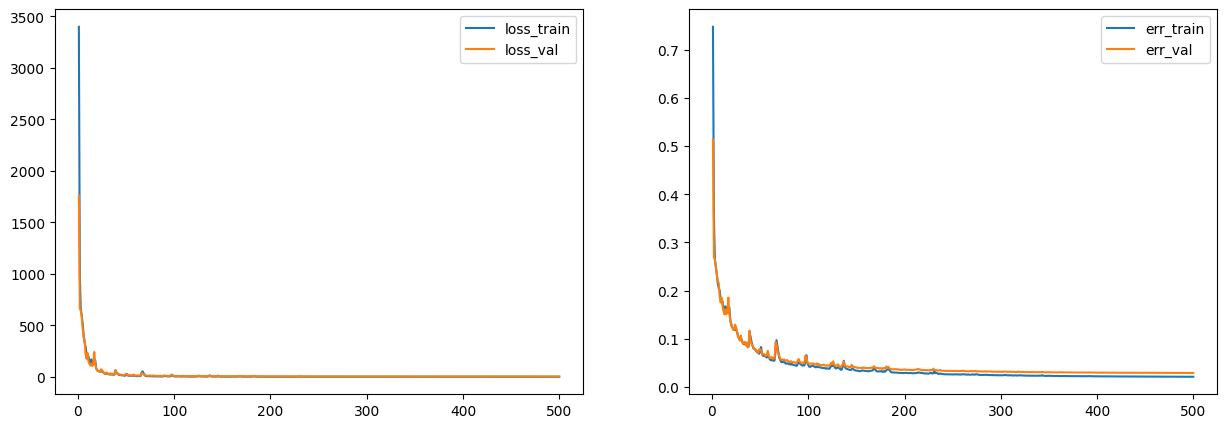

Execution time: 73s
Train epoch 1: loss = 3380.836140950521, error = 0.745887647734748, lr = 0.01
Validation epoch 1: val_loss = 1813.7471137152777, val_error = 0.5181002696355184
Train epoch 101: loss = 3.501952248149448, error = 0.04219936182101568, lr = 0.004047319726783238
Validation epoch 101: val_loss = 9.99568902651469, val_error = 0.050045609308613674
Train epoch 201: loss = 0.9130233645439148, error = 0.028675036794609494, lr = 0.0016380796970808745
Validation epoch 201: val_loss = 5.8453030400806005, val_error = 0.03725612064202626
Train epoch 301: loss = 0.5059058156278399, error = 0.02371683157980442, lr = 0.0006629832272038536
Validation epoch 301: val_loss = 5.304695966508653, val_error = 0.033134820560614266
Train epoch 401: loss = 0.3518661485777961, error = 0.021483222809102802, lr = 0.00026833050939885714
Validation epoch 401: val_loss = 5.0798571586608885, val_error = 0.03073202586836285


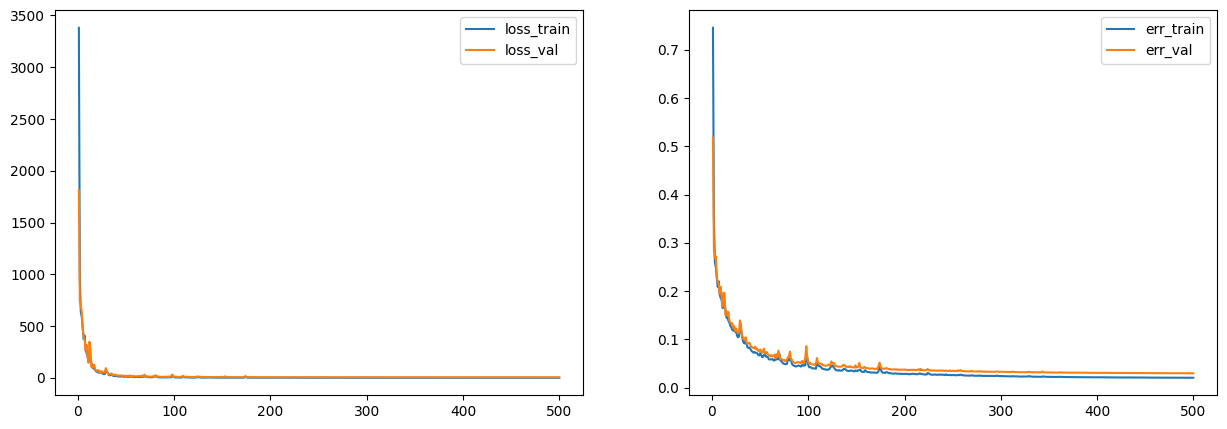

Execution time: 74s
Train epoch 1: loss = 3402.3412977430557, error = 0.7470347748862373, lr = 0.01
Validation epoch 1: val_loss = 1736.4666341145833, val_error = 0.5048449251386854
Train epoch 101: loss = 4.202492676840889, error = 0.043264220737748674, lr = 0.004047319726783238
Validation epoch 101: val_loss = 5.79929232067532, val_error = 0.04592306382126278
Train epoch 201: loss = 0.8996297332975599, error = 0.02746193317903413, lr = 0.0016380796970808745
Validation epoch 201: val_loss = 2.4228871451483833, val_error = 0.03137484772337808
Train epoch 301: loss = 0.6393967105282677, error = 0.024017830193042756, lr = 0.0006629832272038536
Validation epoch 301: val_loss = 2.249821858935886, val_error = 0.028795995314915977
Train epoch 401: loss = 0.37415485580762226, error = 0.021672585813535584, lr = 0.00026833050939885714
Validation epoch 401: val_loss = 2.106680754820506, val_error = 0.027164628066950375


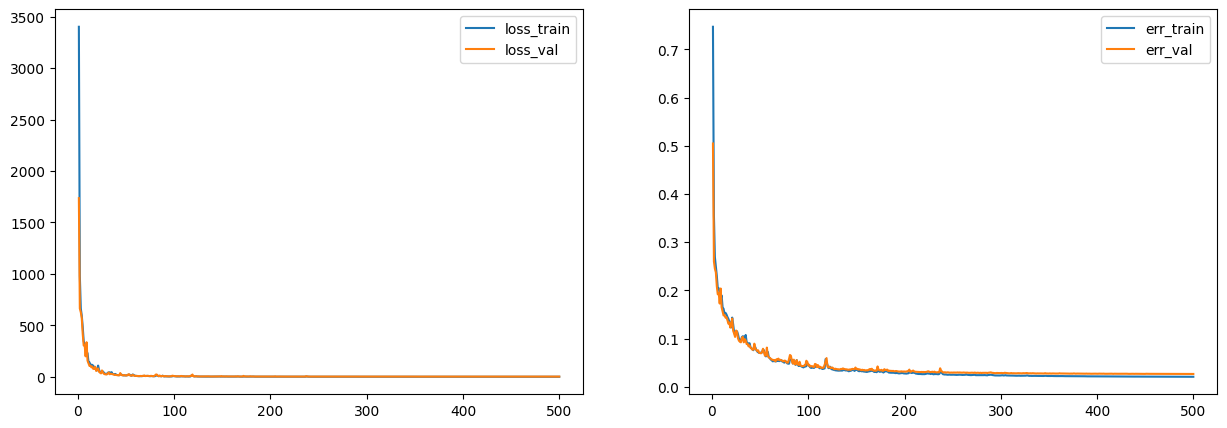

Execution time: 72s


In [ ]:
error, std, t_mean, t_std = cross_validation(folds, x_train_p, y_train_p, PTCMapPressure, K, sv_p, num_epochs, lr, device)

In [ ]:
print("Error: mean = {:.3f}, std = {:.3f}".format(error, std))

Error: mean = 0.026, std = 0.005


In [ ]:
print("Time: mean = {:.3f}, std = {:.3f}".format(t_mean, t_std))

Time: mean = 73.581, std = 0.726
